### Research on Garch

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# 前一天開盤買，index當天開盤賣的預期收益
df = pd.read_parquet("db/tw/pdata/open_pct.parquet")


DatetimeIndex(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-17',
               ...
               '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20',
               '2024-06-21', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', name='da', length=601, freq=None)

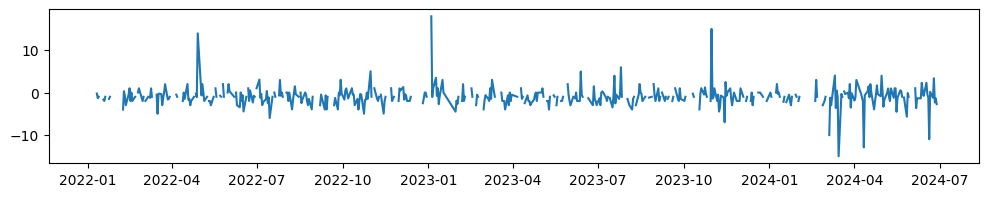

In [9]:
# there's no variance clustering I think, for individual stocks
pct = df['2317'].pct_change().dropna()
plt.figure(figsize=(12, 2))
plt.plot(pct)
plt.show()

In [10]:
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima_model import ARMA
from arch import arch_model
warnings.filterwarnings("ignore")

In [14]:
df_w = df.resample("W-FRI").sum().to_parquet("open_w_fri.paruqet")
df_w.head(5)

ticker,0050,0051,0052,0053,0055,0056,0057,0061,1101,1102,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
da,,,,,,,,,,,,,,,,,,,,,
2022-01-07,0.015901,-0.008220,0.019220,0.012295,0.002857,-0.004140,0.005549,-0.020266,-0.009279,-0.006663,...,-0.013879,-0.011309,0.022704,-0.049110,-0.004972,-0.007981,0.001672,-0.009867,-0.011409,0.040870
2022-01-14,0.017004,-0.004080,0.014052,-0.001042,0.060717,-0.008634,0.010261,-0.006252,0.005334,0.007934,...,0.011355,0.014922,0.052441,0.000499,-0.016742,-0.021084,0.043261,-0.009954,-0.005551,0.009200
2022-01-21,-0.046088,-0.001615,-0.029003,-0.019623,-0.029025,-0.002398,-0.024330,0.013276,-0.007320,-0.002236,...,0.001433,-0.018553,-0.059425,-0.015790,0.000122,-0.032479,-0.014995,-0.003332,-0.005634,-0.039135
2022-01-28,-0.019163,-0.021679,-0.019628,-0.015095,-0.023383,-0.024296,-0.017009,-0.025855,-0.016927,-0.004501,...,-0.022325,-0.017478,-0.028226,-0.020653,-0.003381,-0.004405,-0.036890,-0.020467,-0.014802,-0.059142
2022-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


130


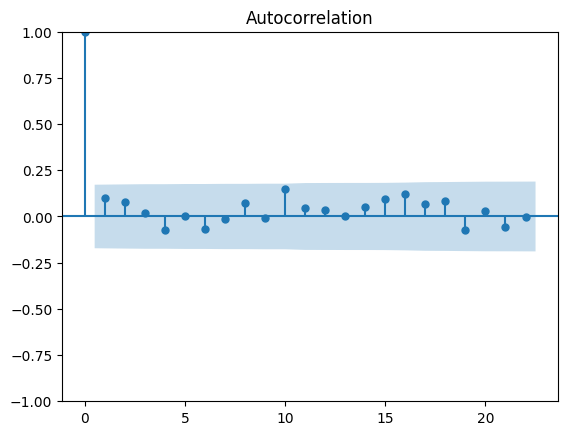

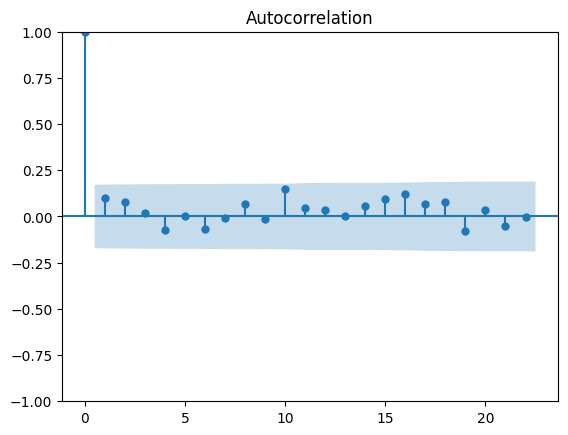

In [53]:
# a = plot_acf(pct) 2, all time
ticker = '0050'
train_pct = df_w[[ticker]]
log_pct = np.log(1 + train_pct)
print(len(train_pct))
_ = plot_acf(train_pct)
_ = plot_acf(log_pct)

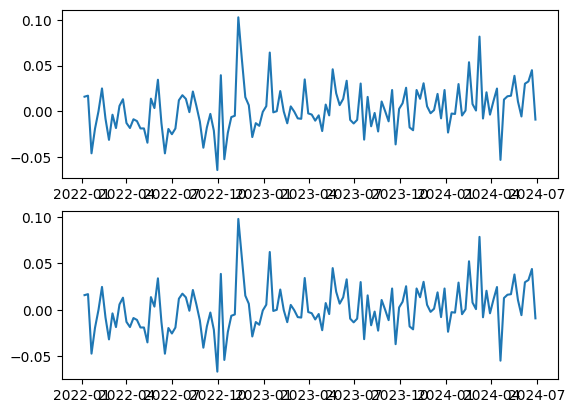

In [34]:
fig, ax = plt.subplots((2))
ax[0].plot(train_pct)
ax[1].plot(log_pct)
plt.show()

In [36]:
train_pct.head(5), log_pct.head(5)

(da
 2022-01-07    0.015901
 2022-01-14    0.017004
 2022-01-21   -0.046088
 2022-01-28   -0.019163
 2022-02-04    0.000000
 Freq: W-FRI, Name: 0050, dtype: float64,
 da
 2022-01-07    0.015776
 2022-01-14    0.016861
 2022-01-21   -0.047184
 2022-01-28   -0.019349
 2022-02-04    0.000000
 Freq: W-FRI, Name: 0050, dtype: float64)

In [40]:
# individual test
model = sm.tsa.arima.ARIMA(log_pct, order=(2, 0, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   0050   No. Observations:                  130
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 296.422
Date:                Tue, 02 Jul 2024   AIC                           -584.845
Time:                        21:05:13   BIC                           -573.375
Sample:                    01-07-2022   HQIC                          -580.184
                         - 06-28-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.680      0.496      -0.003       0.007
ar.L1          0.0926      0.083      1.117      0.264      -0.070       0.255
ar.L2          0.0720      0.108      0.666      0.505      -0.140       0.284
sigma2         0.0006    5.7e-05     10.743      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                23.83
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.51
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
predict_interval = 50
backtest_data_weeks_needed = 52
forecast_pct = np.zeros(predict_interval)
for i in range(predict_interval):
    # print(-predict_interval+i-backtest_data_weeks_needed, -predict_interval+i)
    model = sm.tsa.arima.ARIMA(train_pct[-predict_interval+i-backtest_data_weeks_needed:-predict_interval+i], order=(2, 0, 0))
    model_fit = model.fit()
    forecast_pct[i] = model_fit.forecast(horizon=1).values[0]
predict_pct = train_pct[-predict_interval:]
predict_pct['predict'] = forecast_pct

In [47]:
predict_pct

ticker,0050,predict
da,,
2023-07-21,-0.031118,0.007270
2023-07-28,0.015658,-0.000969
2023-08-04,-0.016536,0.001483
2023-08-11,-0.001903,0.000764
2023-08-18,-0.022172,-0.000747
2023-08-25,0.010624,-0.002547
2023-09-01,0.000109,-0.000562
2023-09-08,-0.011100,0.002624
2023-09-15,0.023200,0.000636


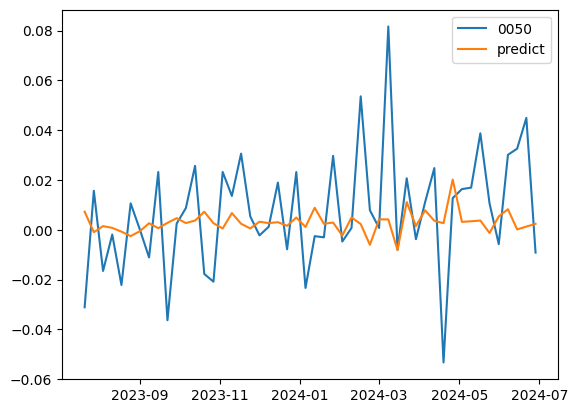

In [48]:
plt.plot(predict_pct, label=predict_pct.columns)
plt.legend()
plt.show()

In [54]:
def check_accuracy(df, series, predict):
    df['signal'] = ((df[series] > 0) & (df[predict] > 0)) | ((df[series] < 0) & (df[predict] < 0))
    correct = df[df['signal'] == True]
    print("accuracy for predicting the same direction:", len(correct)/len(df))
check_accuracy(predict_pct, ticker, 'predict')

accuracy for predicting the same direction: 0.58


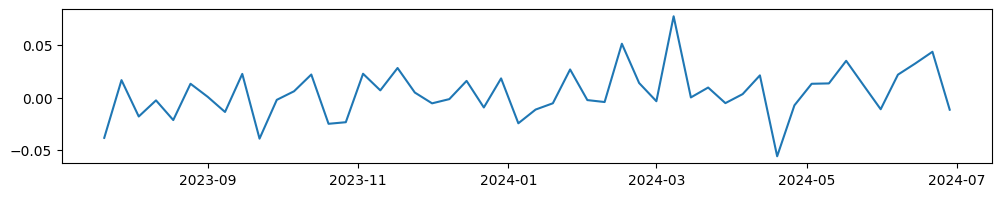

In [56]:
# residual
predict_pct['residual'] = predict_pct[ticker] - predict_pct['predict']
plt.figure(figsize=(12, 2))
plt.plot(predict_pct['residual'])
plt.show()

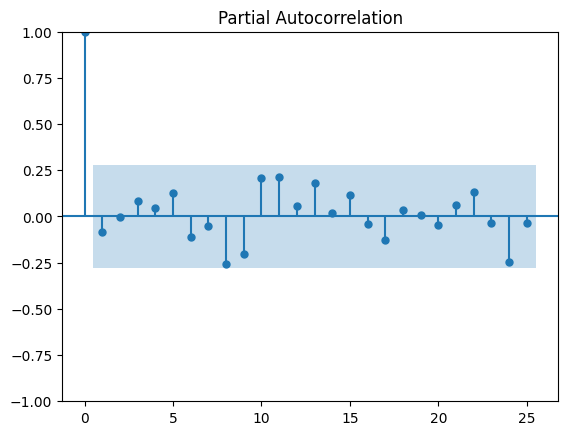

In [59]:
_ = plot_pacf(predict_pct['residual'], lags=25)

In [87]:
predict_interval = 252
forecast_pct = np.zeros(predict_interval)
for i in range(predict_interval):
    model = arch_model(train_pct[-predict_interval+i-252:-predict_interval+i], p=2)
    model_fit = model.fit(disp='off')
    forecast_pct[i] = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, :][0])
predict_arch = train_pct[-predict_interval:]
predict_arch['predict'] = forecast_pct

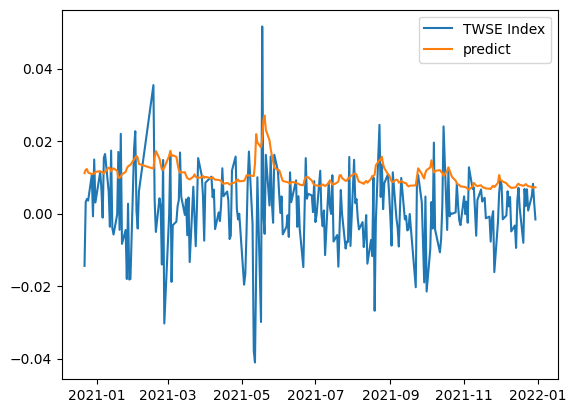

In [88]:
plt.plot(predict_arch, label=predict_arch.columns)
plt.legend()
plt.show()

In [9]:
# loop through ar_t from 1 to 5
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

pct_change = close.pct_change(fill_method=None).dropna(how='all', axis=0)
pct_change.index = pd.to_datetime(pct_change.index)
'''
ar_t = 2
from ${from_t - backtest_interval} days before, 
with backtesting for ${backtest_interval} days each,
looping for ${iter} days as sample data to check accuracy
'''
ar_t = 2
from_t = 150
backtest_interval = 100
iter = from_t - backtest_interval
test = pct_change[['2330.TW']].iloc[-iter:]
for ar_t in range(1, 6):
    predictions = [0.0] * iter 
    for i in range(iter):
        train = pct_change['2330.TW'].iloc[-from_t+i:-from_t+backtest_interval+i]
        model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)
        predictions[i] = prediction.iloc[0]

    test[f'pred_{ar_t}'] = predictions
    
    # calc
    test['pos same'] = (test['2330.TW'] > 0) & (test[f'pred_{ar_t}'] > 0)
    test['neg same'] = (test['2330.TW'] < 0) & (test[f'pred_{ar_t}'] < 0)
    test['same dir'] = test['pos same'] | test['neg same']
    print(f"accuracy before garch for ar_t={ar_t}:", len(test[test['same dir'] == True])/len(test))

'''
# worse, accuracy around 0.3 from 2023-06 to 2023-12
# the pvalues have to be worse at that time interval, so the model could work
# for the stocks with no significant pvalues, set factor value to -1 or sth
'''
print("")

accuracy before garch for ar_t=1: 0.52
accuracy before garch for ar_t=2: 0.5
accuracy before garch for ar_t=3: 0.5
accuracy before garch for ar_t=4: 0.56
accuracy before garch for ar_t=5: 0.58



In [10]:
# test for best lags, maybe exclude other lags
t = 149
for i in range(5):
    train = pct_change['2330.TW'].iloc[-t+i:-t+100+i]
    model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
    model_fit = model.fit()
    prediction = model_fit.forecast(steps=1)
    print("===========")
    print(model_fit.pvalues.iloc[1:6])

ar.L1    0.601109
ar.L2    0.584096
ar.L3    0.968904
ar.L4    0.151602
ar.L5    0.266640
dtype: float64
ar.L1    0.618993
ar.L2    0.599465
ar.L3    0.936515
ar.L4    0.152526
ar.L5    0.201659
dtype: float64
ar.L1    0.606233
ar.L2    0.591512
ar.L3    0.907020
ar.L4    0.146995
ar.L5    0.199925
dtype: float64
ar.L1    0.611463
ar.L2    0.665042
ar.L3    0.882106
ar.L4    0.161712
ar.L5    0.221155
dtype: float64
ar.L1    0.561523
ar.L2    0.670858
ar.L3    0.934330
ar.L4    0.146044
ar.L5    0.221185
dtype: float64


In [11]:
# params for model_fit(summary)
summary = model_fit.summary()
coefficients = model_fit.params
standard_errors = model_fit.bse
p_values = model_fit.pvalues
aic = model_fit.aic
bic = model_fit.bic
p_values

const     6.985348e-03
ar.L1     5.615231e-01
ar.L2     6.708576e-01
ar.L3     9.343299e-01
ar.L4     1.460442e-01
ar.L5     2.211851e-01
sigma2    7.512556e-18
dtype: float64